# Importing Libraries
## Make sure you have the requisite requirements

In [1]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

In [2]:
def correct_quandl_name(names):
    if isinstance(names, str):
        names = [names]
    return names

In [3]:
def request_quandl(names, start_date=None, end_date=None, token=None):
    c_names = correct_quandl_name(names)
    response = quandl.get(c_names, start_date = start_date, end_date = end_date, authtoken=token)
    return response

In [4]:
def request_yfinance(names, start_date=None, end_date=None):
    if isinstance(start_date, str):
        start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    if isinstance(end_date, str):
        start_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    response = yf.download(names, start=start_date, end=end_date)
    if not isinstance(response.columns, pd.MultiIndex) and len(names) > 0:
        stock_tuples = [(col, names[0]) for col in list(response.columns)]
        response.columns = pd.MultiIndex.from_tuples(stock_tuples)
    return response

In [30]:
def get_stock_data(names, start_date = None, end_date = None):
    #overall_Data = {}
    data = request_yfinance(names, start_date=start_date, end_date=end_date)
    data = data["Adj Close"]
    #overall_Data[name] = data['Adj Close']
    #overall_Data = pd.concat(overall_Data, axis=1)
    return data

In [6]:
def log_hist_returns(df):
    hist_returns = np.log(df/df.shift())
    hist_returns = hist_returns.dropna()
    return hist_returns

In [7]:
def hist_mean(df):
    hist_mean = df.mean(axis=0).to_frame()
    hist_mean.columns = ['MU']
    return hist_mean.transpose()

In [8]:
def hist_cov_and_corr(df):
    hist_cov = df.cov()
    hist_corr = df.corr()
    return (hist_cov, hist_corr)

In [9]:
def gmv(names, cov, mean_data):    
    hist_cov_inv = -np.linalg.inv(cov)
    ones = np.ones(len(names))
    weights_gmv = np.dot(hist_cov_inv, ones)/(np.dot(ones.transpose(), np.dot(hist_cov_inv, ones)))
    weights_gmv_df = pd.DataFrame(data = weights_gmv).transpose()
    weights_gmv_df.columns = names
    stddev_gmv = np.sqrt(np.dot(weights_gmv.T, np.dot(cov, weights_gmv))) * np.sqrt(250)
    return_gmv = np.dot(weights_gmv.transpose(), mean_data.transpose())*252
    
    return (weights_gmv_df, stddev_gmv, return_gmv)

In [10]:
def max_return(names, mean_data, cov):
    cov_inv = -np.linalg.inv(cov)
    ones = np.ones(len(names))
    mu_o = np.asscalar(np.max(mean_data.T))
    
    A = np.matrix([[np.asscalar(np.dot(mean_data,np.dot(cov_inv,mean_data.T))),
                np.asscalar(np.dot(mean_data,np.dot(cov_inv,ones)))],
               [np.asscalar(np.dot(mean_data,np.dot(cov_inv,ones))),
                np.asscalar(np.dot(ones.T,np.dot(cov_inv,ones)))]])
    B = np.hstack([np.array(mean_data.T), ones.reshape(len(names), 1)])
    y = np.matrix([mu_o, 1]).T
    
    weights_max_returns = np.dot(np.dot(np.dot(cov_inv, B), np.linalg.inv(A)), y)
    weights_max_returns_df = pd.DataFrame(weights_max_returns).T
    weights_max_returns_df.columns = names
    
    stddev_max_returns = np.sqrt(np.dot(weights_max_returns.T, np.dot(cov, weights_max_returns))) * np.sqrt(250)
    return_max_returns = np.dot(weights_max_returns.transpose(), mean_data.transpose())*252
    
    return (weights_max_returns_df, stddev_max_returns, return_max_returns)

In [11]:
def construct_portfolios(names, start_date = None, end_date = None):
    
    print("----------------------------------\n")
    print("LIST OF STOCKS - \n")
    for name in names:
        print(name+"\n")
    print("----------------------------------\n")
    
    
    data = get_stock_data(names=names, start_date = '2019-01-01')
    
    hist_return = log_hist_returns(data)
    hist_mean_data = hist_mean(hist_return)
    
    print("Log Mean Returns - \n")
    print(hist_mean_data)
    print('\n\n')
    
    (hist_cov, hist_corr) = hist_cov_and_corr(hist_return)
    
    print("Historical Covariance - \n")
    print(hist_cov)
    print('\n\n')
    
    print("Historical Correlation - \n")
    print(hist_corr)
    
    #Construct random portfolios
    
    n_portfolios = 5000
    p_returns = np.zeros(n_portfolios)
    p_stddevs = np.zeros(n_portfolios)
    
    for i in range(n_portfolios):
        weights = np.random.rand(len(names))
        weights = weights/sum(weights)
        portfolio_return = np.dot(weights.transpose(), hist_mean_data.transpose())*252
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(hist_cov, weights))) * np.sqrt(250)
        p_returns[i] = portfolio_return
        p_stddevs[i] = portfolio_stddev

    #GMV
    (weights_gmv_df, stddev_gmv, return_gmv) = gmv(names, hist_cov, hist_mean_data)
    (weights_max_returns_df, stddev_max_returns, return_max_returns) =  max_return(names, hist_mean_data, hist_cov)
    
    print("\n----------------------------------\n")
    print("Weights for global minimum variance")
    print(weights_gmv_df)
    print("\n\nVariance at GMV")
    print(stddev_gmv)
    print("\n\nReturn at GMV")
    print(return_gmv)
    
    print("\n----------------------------------\n")
    print("Weights for Minimum Risk at Maximum Returns")
    print(weights_max_returns_df)
    print("\n\nVariance at Max Returns")
    print(stddev_max_returns)
    print("\n\nReturn at Max Returns")
    print(return_max_returns)
    
    
    plt.figure(figsize=(10,10))
    plt.plot(p_stddevs, p_returns, 'o')
    plt.plot(stddev_gmv, return_gmv, 'x', markersize=20)
    plt.plot(stddev_max_returns, return_max_returns, 'o', markersize=20)
    plt.xlabel('Expected Risk')
    plt.ylabel('Expected Return')
    plt.title('Return and Volatility of Randomly Generated Portfolios')
    plt.show()

# Plotting indicators

In [12]:
def sma(data, span, num=True):
    ma_window1 = pd.DataFrame()
    ma_window1 = data.rolling(window=span[0]).mean()
    ma_window2 = pd.DataFrame();
    ma_window2 = data.rolling(window=span[1]).mean()
    if num:
        return ma_window1, ma_window2
    else:
        ma_window1.columns = pd.MultiIndex.from_product([['Fast'], ma_window1.columns])
        ma_window2.columns = pd.MultiIndex.from_product([['Slow'], ma_window2.columns])
        ma = pd.concat([ma_window1, ma_window2], axis = 1)
        return ma

In [13]:
def plot_sma(data, fun, span, num=True):
    ma1, ma2 = fun(data, span=span)
    tickers = ma1.columns
    signal = ma1-ma2
    signal[signal>0] = 1
    signal[signal<0] = -1
    signal = signal.diff()
    for tick in tickers:
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)       
        ax.plot(signal[tick].loc[signal[tick] == 2.0].index.values, ma1[tick][signal[tick]==2.0].values,marker="^",markersize=10,color="b",label="buy signal",linewidth=0)
        ax.plot(signal[tick].loc[signal[tick] == -2.0].index.values, ma1[tick][signal[tick]==-2.0].values,marker="v",markersize=10,color="r",label="sell signal",linewidth=0)
#         for line in ax.get_lines(): # ax.lines:
#             line.remove()
        ma1[tick].plot(label= str(span[0]) + ' Day Avg', color = 'r')
        ma2[tick].plot(label= str(span[1]) + ' Day Avg', color = 'g')
        data[tick].plot(label=tick + ' CLOSE')
        plt.legend()

In [14]:
def ema(data, span, plot=True):
    ema = pd.DataFrame()
    ema = data.ewm(span=span, adjust=False).mean()
    if plot:
        tickers = ema.columns
        for tick in tickers:
            plt.figure(figsize=(12,6))
            ema[tick].plot(label= str(span) + ' Day Exponential Avg')
            data[tick].plot(label=tick + ' CLOSE')
            plt.legend()
    return ema

In [35]:
def bbands(data, span):
    tickers = data.columns
    for tick in tickers:
        rolling_mean=data[tick].rolling(span).mean()
        upper_band=rolling_mean+2*data[tick].rolling(span).std()
        lower_band=rolling_mean-2*data[tick].rolling(span).std()
        plt.figure(figsize=(12,6))
        data[tick].plot(figsize=(10,5),title='20 Day Rolling Bollinger Bands').fill_between(data[tick].index,lower_band,upper_band,alpha=0.1)        
        plt.plot(upper_band,label='Upper Band',color='red')
        plt.plot(lower_band,label='Lower Band',color='orange')
        plt.legend()

## Test Run SMA and BBands


In [31]:
response = get_stock_data(names = ["ITC.NS","BPCL.NS","RELIANCE.NS","BEL.NS","TCS.NS"], start_date = "2019-01-01")
ma1, ma2 = sma(response, [5,10], num = True)#If num is True function will return 2 different df for slow and fast moving avg

[*********************100%***********************]  5 of 5 completed


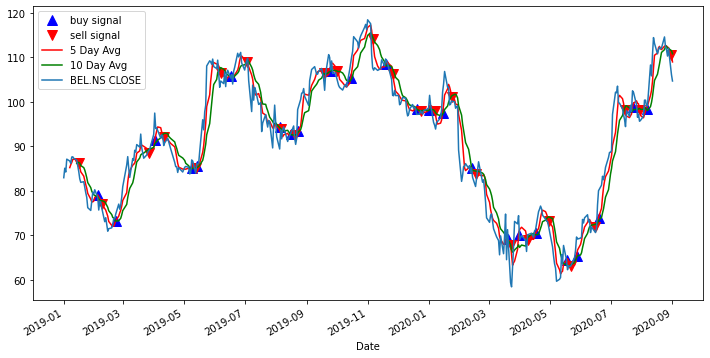

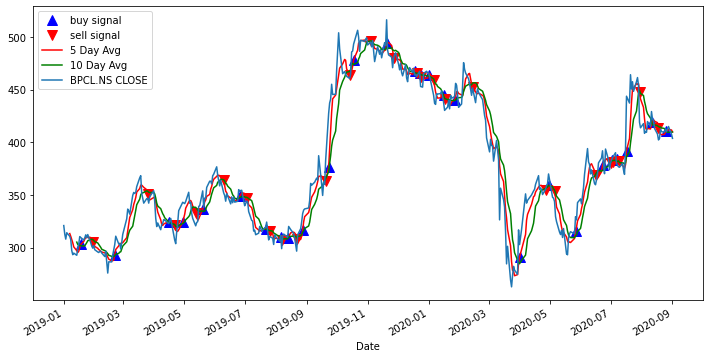

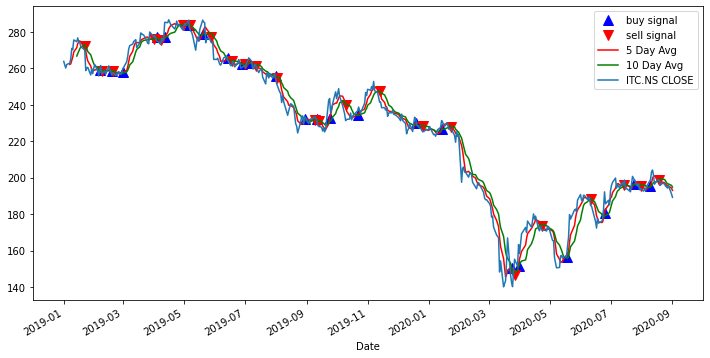

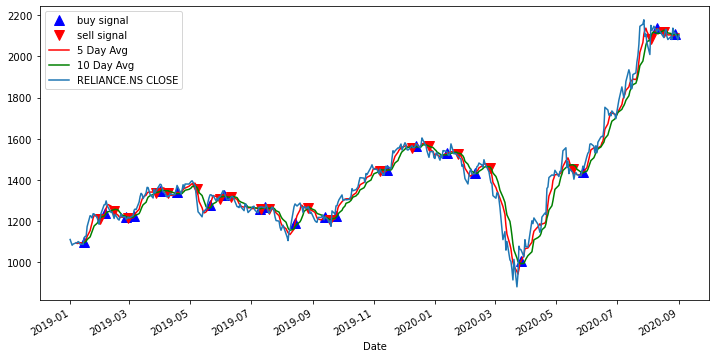

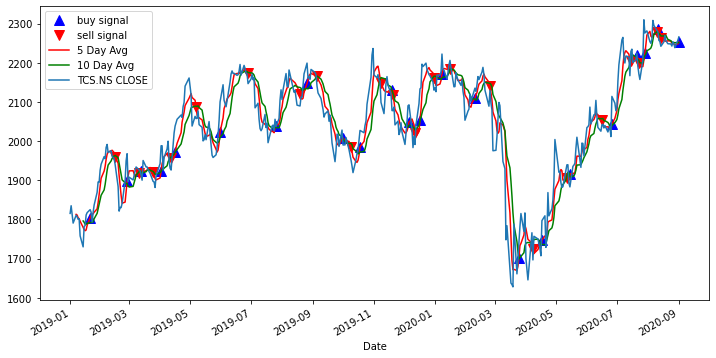

In [33]:
plot_sma(response, sma, [5,10])

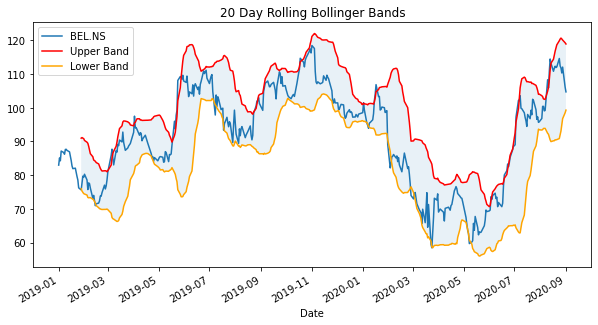

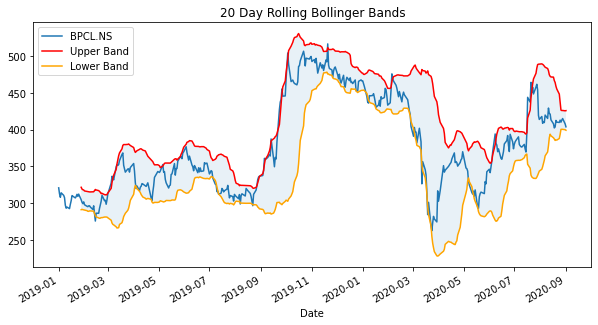

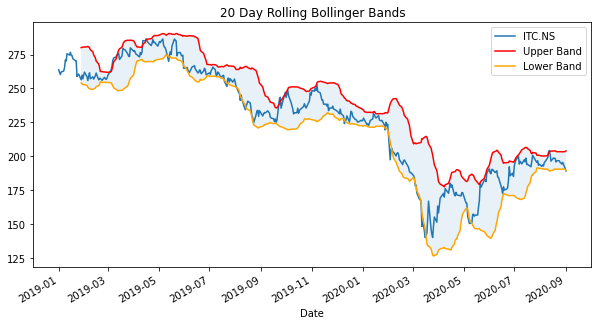

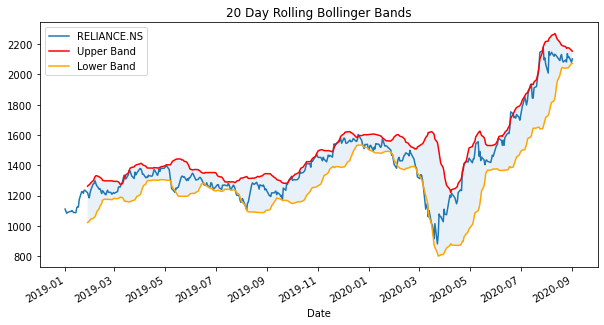

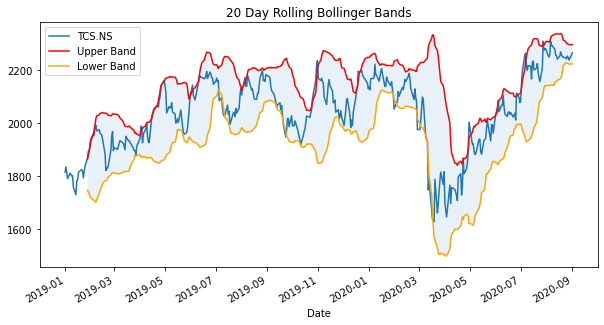

In [36]:
bbands(response, 20)